# 1-norm Control

In [1]:
import numpy as np
import matplotlib.pylab as plt
import cvxpy as cp
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
    })

In [5]:
# Problem data
T = 100
h = 0.1
eta = 0.1
mass = 1
n = 4
m = 2

# Model
A = np.array([[1, 0, h, 0],
              [0, 1, 0, h],
              [0, 0, 1 - h * eta, 0],
              [0, 0, 0, 1 - h * eta]])
B = np.array([[0, 0],
              [0, 0],
              [h, 0],
              [0, h]])
C = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

# Initial value
x_init = np.array([0, 3, 0, 0])
# x_init = np.zeros(4)

# Output to track
y_des = 0.1 * np.vstack([np.hstack([np.arange(1, int(T/2) + 1).reshape(-1, 1), 50 * np.ones((int(T/2), 1))]),
                         np.hstack([50 * np.ones((int(T/2), 1)), np.arange(int(T/2), 0, -1).reshape(-1, 1)])])

In [6]:
# Setup tracking problem
rho = 0.1

u = cp.Variable((T-1, m))
x = cp.Variable((T, n))

tracking_error = 0
input_effort = 0
dynamics = []
for t in range(T-1):
    tracking_error += cp.sum_squares(C @ x[t] - y_des[t])
    input_effort += cp.sum_squares(u[t])
    dynamics += [x[t+1] == A @ x[t] + B @ u[t]]
    
tracking_error += cp.sum_squares(C @ x[T-1] - y_des[T-1])
    
initial_state = [x[0] == x_init]
    
    
problem = cp.Problem(cp.Minimize(tracking_error + rho * input_effort),
                     dynamics + initial_state)

problem.solve()

40.932706681461255

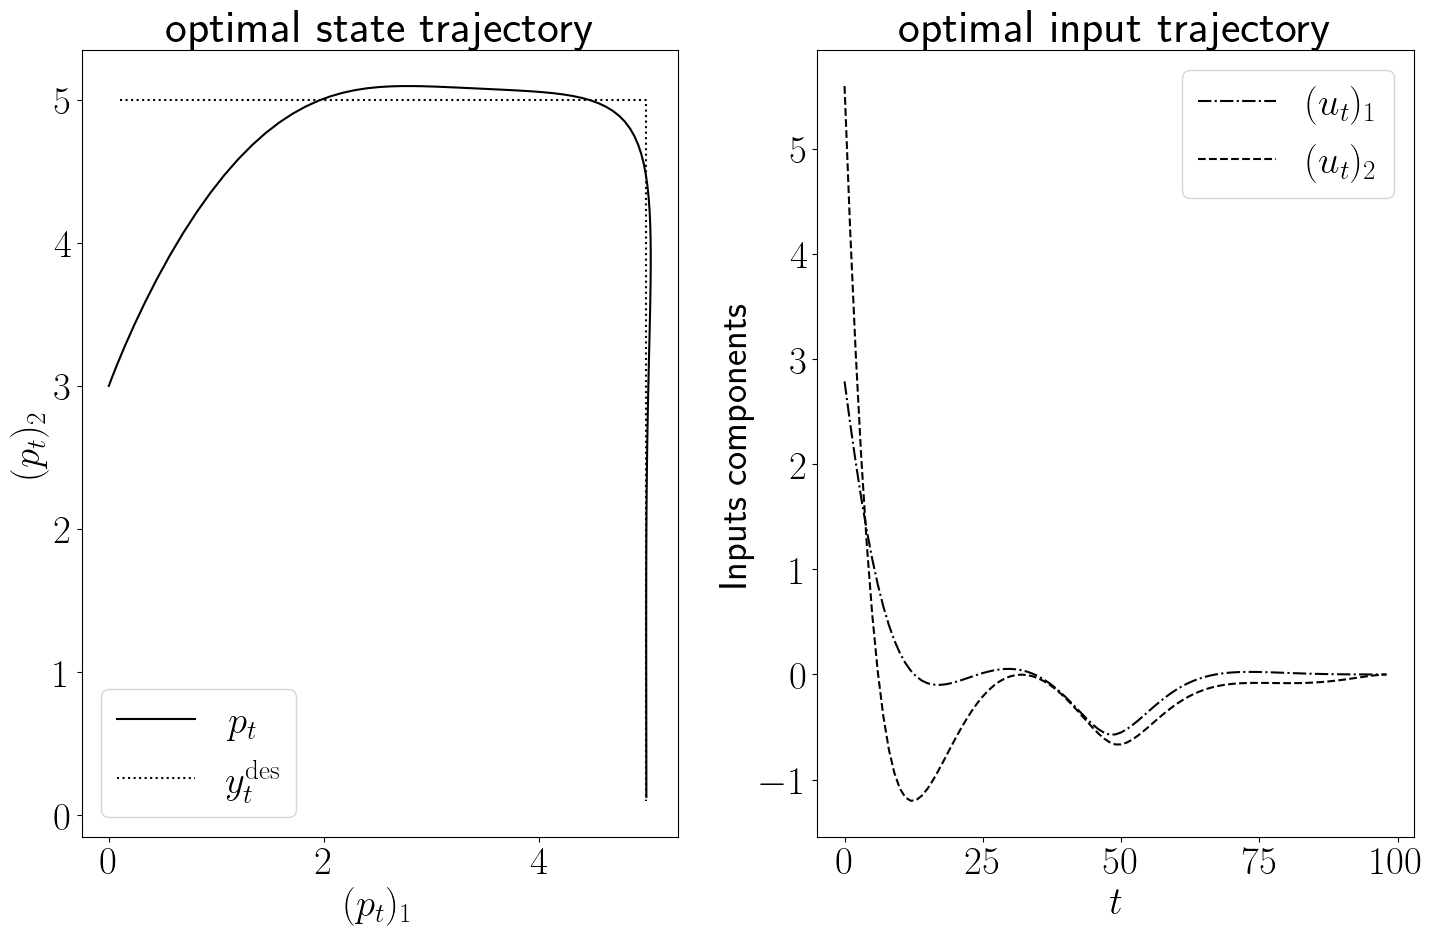

In [7]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].plot(x[:, 0].value, x[:, 1].value, color="k", label=r"$p_t$")
ax[0].plot(y_des[:, 0], y_des[:, 1], color="k", linestyle="dotted", label=r"$y^{\rm des}_t$")
ax[0].set_title('optimal state trajectory')
ax[0].set_xlabel(r'$(p_t)_1$')
ax[0].set_ylabel(r'$(p_t)_2$')
ax[0].legend()

ax[1].plot(u[:, 0].value, color="k", linestyle="-.", label=r"$(u_t)_1$")
ax[1].plot(u[:, 1].value, color="k", linestyle="--", label=r"$(u_t)_2$")
ax[1].set_title('optimal input trajectory')
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel('Inputs components')
ax[1].legend()
plt.tight_layout()
plt.savefig("least_squares_control.pdf")

In [14]:
# Setup tracking problem
rho = 0.1

u = cp.Variable((T-1, m))
x = cp.Variable((T, n))

tracking_error = 0
input_effort = 0
dynamics = []
for t in range(T-1):
    tracking_error += cp.norm(C @ x[t] - y_des[t], 1)
    input_effort += cp.norm(u[t], 1)
    dynamics += [x[t+1] == A @ x[t] + B @ u[t]]
    
tracking_error += cp.norm(C @ x[T-1] - y_des[T-1], 1)
    
initial_state = [x[0] == x_init]
    
    
problem = cp.Problem(cp.Minimize(tracking_error + rho * input_effort),
                     dynamics + initial_state)

problem.solve()

20.708278676650306

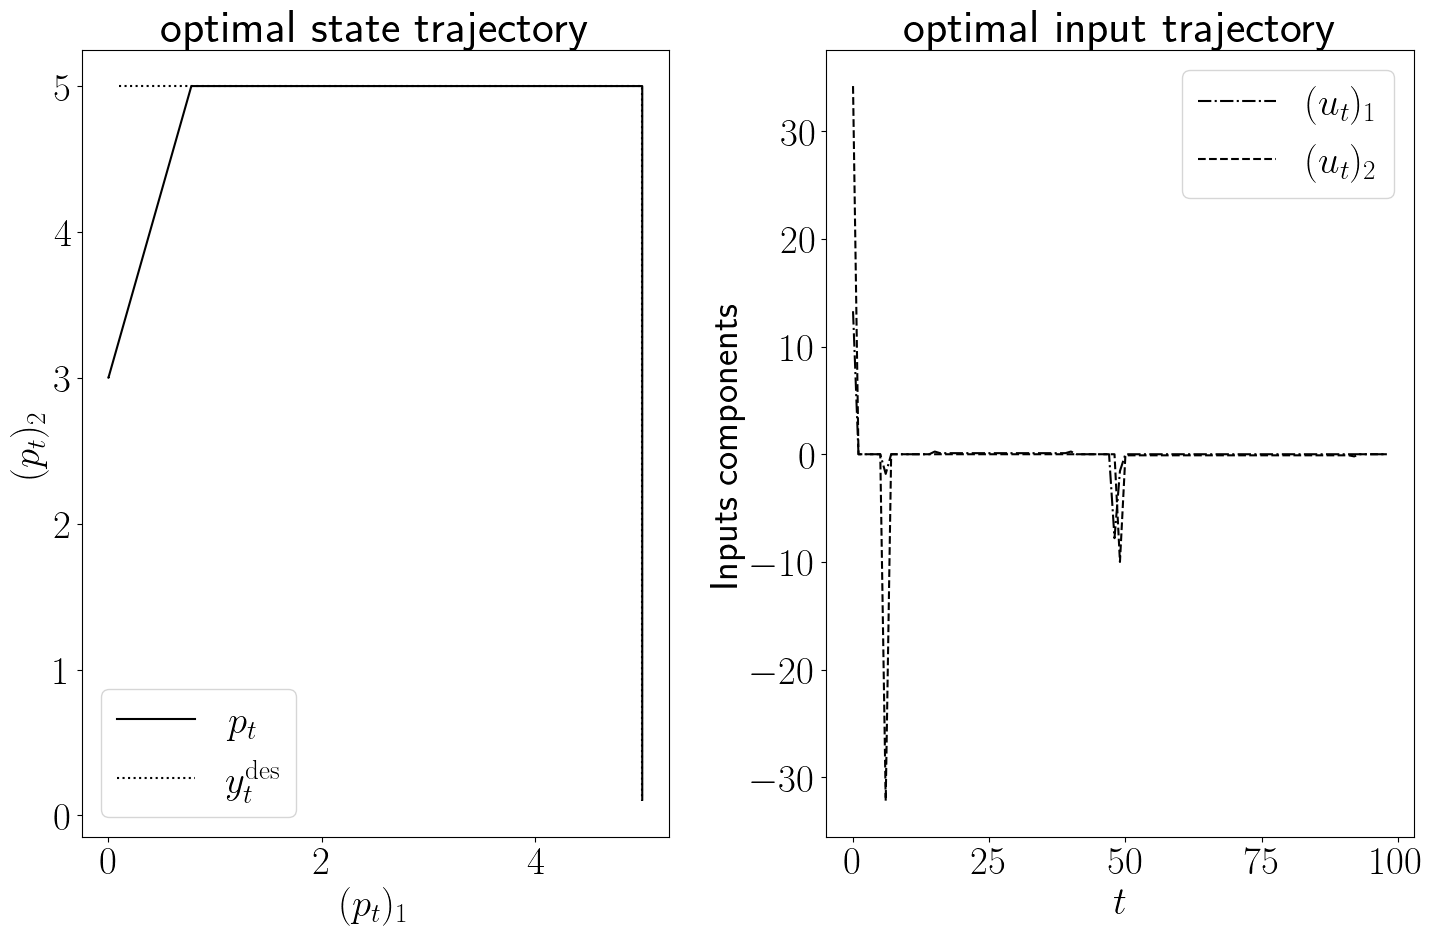

In [15]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].plot(x[:, 0].value, x[:, 1].value, color="k", label=r"$p_t$")
ax[0].plot(y_des[:, 0], y_des[:, 1], color="k", linestyle="dotted", label=r"$y^{\rm des}_t$")
ax[0].set_title('optimal state trajectory')
ax[0].set_xlabel(r'$(p_t)_1$')
ax[0].set_ylabel(r'$(p_t)_2$')
ax[0].legend()

ax[1].plot(u[:, 0].value, color="k", linestyle="-.", label=r"$(u_t)_1$")
ax[1].plot(u[:, 1].value, color="k", linestyle="--", label=r"$(u_t)_2$")
ax[1].set_title('optimal input trajectory')
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel('Inputs components')
ax[1].legend()
plt.tight_layout()
plt.savefig("1_norm_control.pdf")

In [16]:
# Tracking problem with max input and max input variation constraints
rho = 0.1
u_max = 10
s_max = 0.1
u_prev = np.array([0, 0])

u = cp.Variable((T-1, m))
x = cp.Variable((T, n))

tracking_error = 0
input_effort = 0
dynamics = []
max_input = []
max_input_variation = [cp.norm(u[0] - u_prev, np.inf) <= s_max]
for t in range(T-1):
    tracking_error += cp.norm(C @ x[t] - y_des[t], 1)
    input_effort += cp.norm(u[t], 1)
    dynamics += [x[t+1] == A @ x[t] + B @ u[t]]
    max_input += [cp.norm(u[t], np.inf) <= u_max]
    
for t in range(1, T-1):
    max_input_variation += [cp.norm(u[t] - u[t-1], np.inf) <= s_max]
    
tracking_error += cp.norm(C @ x[T-1] - y_des[T-1], 1)
    
initial_state = [x[0] == x_init]
    
    
problem = cp.Problem(cp.Minimize(tracking_error + rho * input_effort),
                     dynamics + 
                     initial_state + 
                     max_input + 
                     max_input_variation)

problem.solve()

71.62888600779894

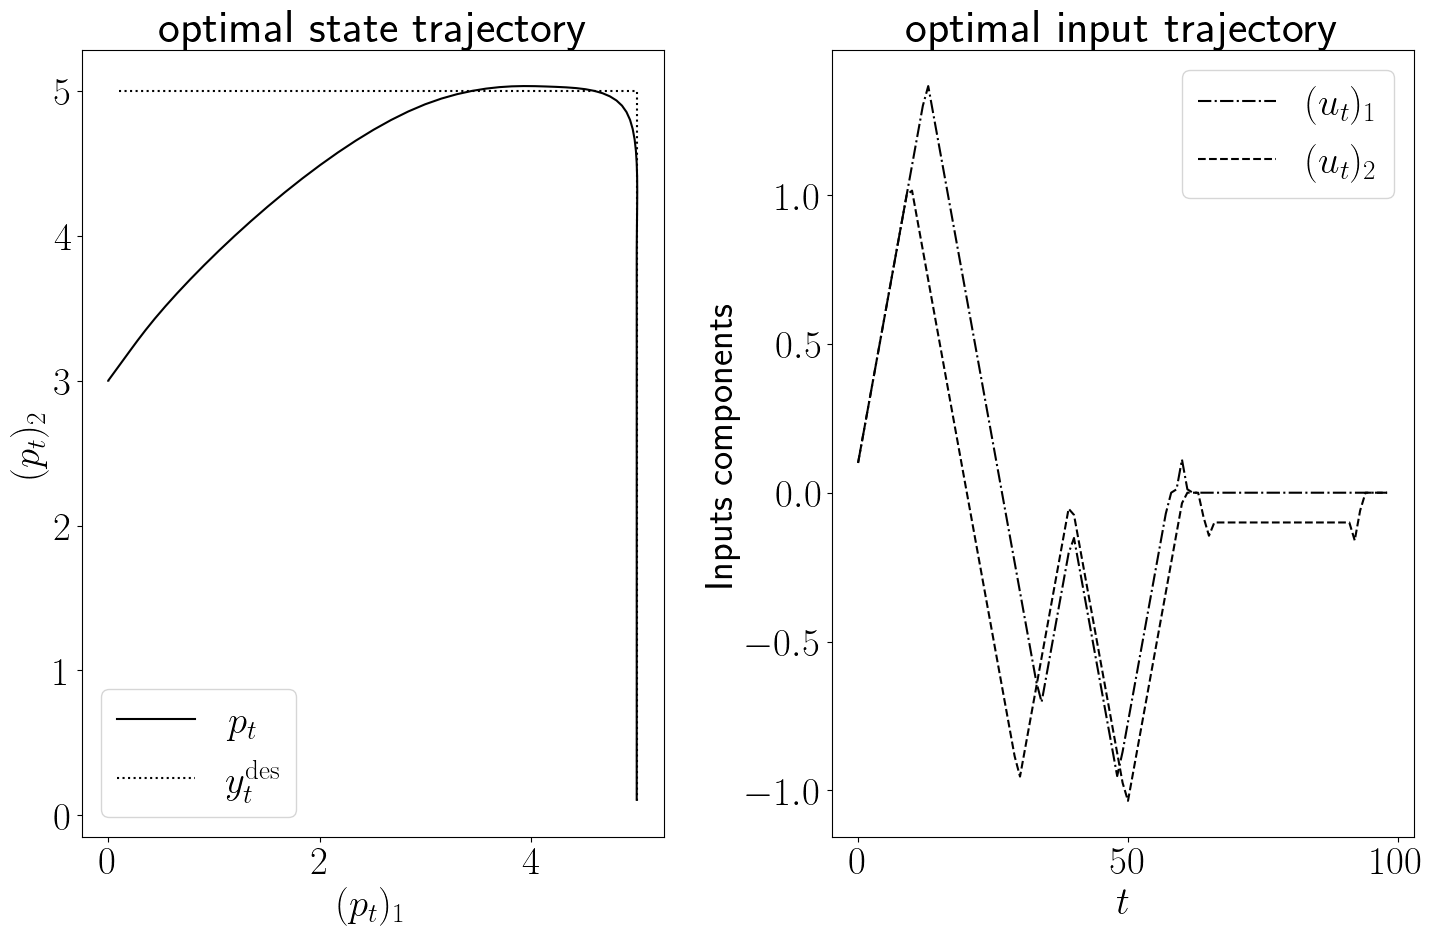

In [17]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].plot(x[:, 0].value, x[:, 1].value, color="k", label=r"$p_t$")
ax[0].plot(y_des[:, 0], y_des[:, 1], color="k", linestyle="dotted", label=r"$y^{\rm des}_t$")
ax[0].set_title('optimal state trajectory')
ax[0].set_xlabel(r'$(p_t)_1$')
ax[0].set_ylabel(r'$(p_t)_2$')
ax[0].legend()

ax[1].plot(u[:, 0].value, color="k", linestyle="-.", label=r"$(u_t)_1$")
ax[1].plot(u[:, 1].value, color="k", linestyle="--", label=r"$(u_t)_2$")
ax[1].set_title('optimal input trajectory')
ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel('Inputs components')
ax[1].legend()
plt.tight_layout()
plt.savefig("1_norm_input_constrained_control.pdf")